In [2]:
import sympy as sym
from sympy import Matrix
import math

from mitroiki_functs import K_truss
from mitroiki_functs import TransformMatrixTruss
from mitroiki_functs import round_expr
import matplotlib.pyplot as plt
import numpy as np

import openseespy.opensees as ops
import opsvis as opsv


from IPython.display import Image

# Εφαρμογή 9 - Δικτύωμα

Να υπολογιστούν οι αντιδράσεις στήριξης, οι παραμορφώσεις και τo διάγραμμα αξονικών δυνάμεων για τον φορέα του σχήματος.

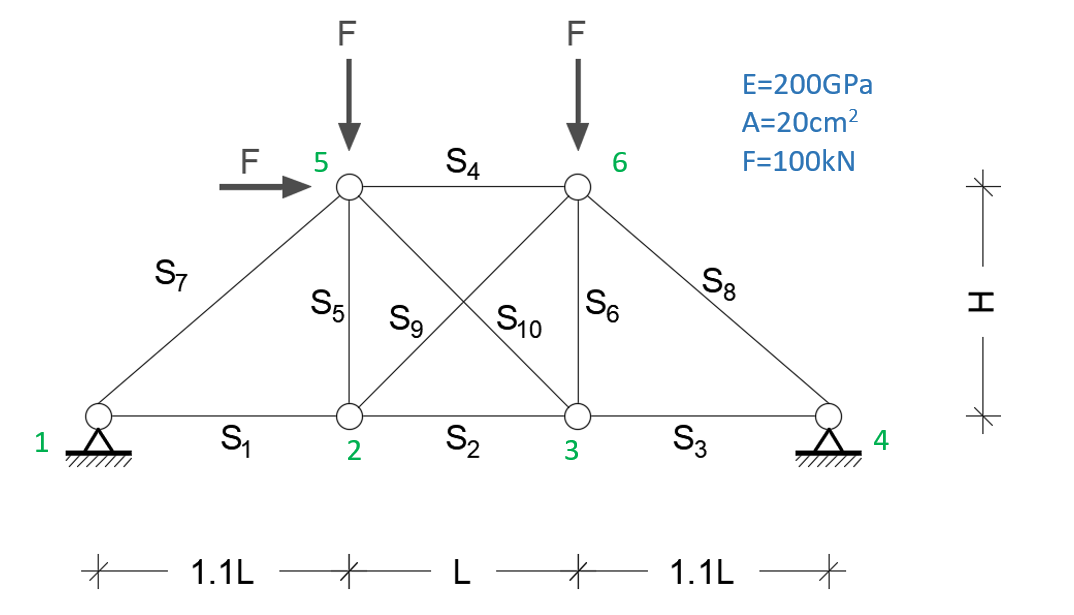

In [12]:
Image("img/ekfonisi.png", width=700)
# Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/ekfonisi.png", width=600)

In [10]:
E = 200_000_000.           # kN/m2
A = 20e-4                  # m2

L = 5.                     # m
H = 5.                     # m

F = 100.                   # kN

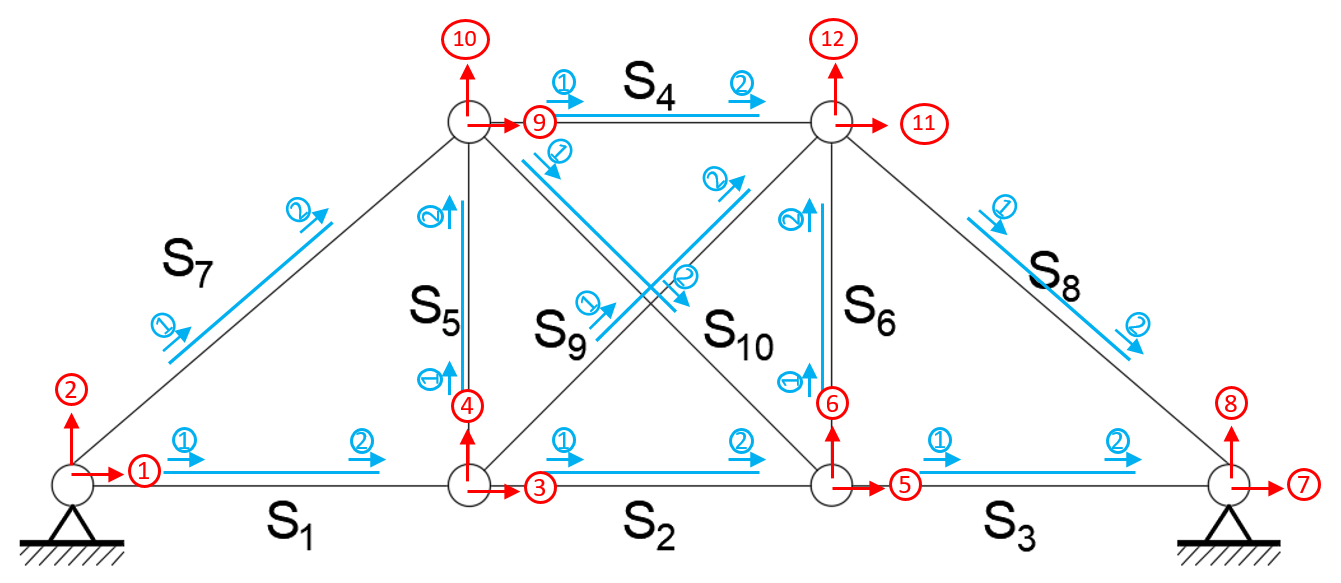

In [13]:
Image("img/dof_global_local.png", width=700)
# Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/dof_global_local.png", width=500)

## Μητρώα στιβαρότητας στοιχείων

### Μήκη ράβδων

In [21]:
l=[0]*10
# Οριζόντιες ράβδοι βάσης S1, S2, S3
l[0] = 1.1*L
l[1] = L
l[2] = 1.1*L
# Οριζόντια ράβδος οροφής S4
l[3] = L
# Κατακόρυφες ράβδοι S5, S6
l[4] = H
l[5] = H
# Κεκλιμένες εξωτερικές ράβδοι S7, S8
l[6] = math.sqrt((1.1*L)**2 + H**2)
l[7] = math.sqrt((1.1*L)**2 + H**2)
# Κεκλιμένες εσωτερικές ράβδοι S9, S10
l[8] = math.sqrt(L**2 + H**2)
l[9] = math.sqrt(L**2 + H**2)

print(l[6])
print(l[8])

7.433034373659253
7.0710678118654755


### Γωνίες

In [35]:
θ=[0]*10
# Οριζόντιες ράβδοι βάσης S1, S2, S3
θ[0] = 0
θ[1] = 0
θ[2] = 0
# Οριζόντια ράβδος οροφής S4
θ[3] = 0
# Κατακόρυφες ράβδοι S5, S6
θ[4] = math.pi/2
θ[5] = math.pi/2
# Κεκλιμένες εξωτερικές ράβδοι S7, S8
θ[6] = math.atan(H/(1.1*L))
θ[7] = -math.atan(H/(1.1*L))
# Κεκλιμένες εσωτερικές ράβδοι S9, S10
θ[8] = math.atan(H/L)
θ[9] = -math.atan(H/L)

print(θ[6])
print(θ[8])

0.7378150601204649
0.7853981633974483


In [28]:
K = [K_truss(A=A,
            E=E,
            L=l_tmp) for l_tmp in l]

In [29]:
K[0]

Matrix([
[ 72727.2727272727, -72727.2727272727],
[-72727.2727272727,  72727.2727272727]])

## Μητρώα μετασχηματισμού και μετατροπή των μητρώων στιβαρότητας

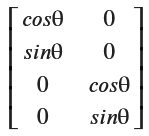

In [6]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/trans_matrix_truss.png", width=120)

In [36]:
Λ = [TransformMatrixTruss(θ_tmp) for θ_tmp in θ]

In [40]:
round_expr(Λ[0], 4)

Matrix([
[1, 0],
[0, 0],
[0, 1],
[0, 0]])

In [39]:
round_expr(Λ[4], 4)

Matrix([
[  0,   0],
[1.0,   0],
[  0,   0],
[  0, 1.0]])

In [41]:
round_expr(Λ[6], 4)

Matrix([
[0.7399,      0],
[0.6727,      0],
[     0, 0.7399],
[     0, 0.6727]])

In [42]:
round_expr(Λ[8], 4)

Matrix([
[0.7071,      0],
[0.7071,      0],
[     0, 0.7071],
[     0, 0.7071]])

### Μετασχηματισμένα μητρώα στιβαρότητας

In [43]:
K_trans = [Λ[i] * K[i] * Λ[i].transpose() for i in range(10)]    

In [47]:
round_expr(K_trans[0], 4)

Matrix([
[ 72727.2727, 0, -72727.2727, 0],
[          0, 0,           0, 0],
[-72727.2727, 0,  72727.2727, 0],
[          0, 0,           0, 0]])

In [48]:
round_expr(K_trans[1], 4)

Matrix([
[ 80000.0, 0, -80000.0, 0],
[       0, 0,        0, 0],
[-80000.0, 0,  80000.0, 0],
[       0, 0,        0, 0]])

Παρατηρείται ότι ενώ τα αρχικά μητρώα στιβαρότητας στο τοπικό σύστημα των ράβδων (μόνο για την αξονική δράση) είναι 2x2, μετά τη χρήση των μητρώων μετασχηματισμού μετατρέπονται σε 4x4, στο καθολικό σύστημα συντεταγμένων)

## Αντιστοίχιση τοπικών - καθολικών βαθμών ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) | (10) | (11) | (12) |
| ------------ | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---- | ---- | ---- |
| S1           | 1   | 2   | 3   | 4   |     |     |     |     |     |      |      |      |
| S2           |     |     | 1   | 2   | 3   | 4   |     |     |     |      |      |      |
| S3           |     |     |     |     | 1   | 2   | 3   | 4   |     |      |      |      |
| S4           |     |     |     |     |     |     |     |     |  1  | 2    | 3    | 4    |
| S5           |     |     | 1   | 2   |     |     |     |     |  3  | 4    |      |      |
| S6           |     |     |     |     | 1   | 2   |     |     |     |      | 3    | 4    |
| S7           | 1   | 2   |     |     |     |     |     |     |  3  | 4    |      |      |
| S8           |     |     |     |     |     |     | 3   | 4   |     |      | 1    | 2    |
| S9           |     |     | 1   | 2   |     |     |     |     |     |      | 3    | 4    |
| S10          |     |     |     |     | 3   | 4   |     |     |  1  | 2    |      |      |

In [86]:
K_temp = [None] * 10

In [87]:
K_temp[0] = sym.zeros(12,12)
K_temp[0][:4, :4] += K_trans[0]
round_expr(K_temp[0], 1)

Matrix([
[ 72727.3, 0, -72727.3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[-72727.3, 0,  72727.3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[       0, 0,        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [88]:
K_temp[1] = sym.zeros(12,12)
K_temp[1][2:6, 2:6] += K_trans[1]
round_expr(K_temp[1], 1)

Matrix([
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,  80000.0, 0, -80000.0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, -80000.0, 0,  80000.0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0],
[0, 0,        0, 0,        0, 0, 0, 0, 0, 0, 0, 0]])

In [89]:
K_temp[2] = sym.zeros(12,12)
K_temp[2][4:8, 4:8] += K_trans[2]
round_expr(K_temp[2], 1)

Matrix([
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,  72727.3, 0, -72727.3, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, -72727.3, 0,  72727.3, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0],
[0, 0, 0, 0,        0, 0,        0, 0, 0, 0, 0, 0]])

In [90]:
K_temp[3] = sym.zeros(12,12)
K_temp[3][8:, 8:] += K_trans[3]
round_expr(K_temp[3], 1)

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,  80000.0, 0, -80000.0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, -80000.0, 0,  80000.0, 0],
[0, 0, 0, 0, 0, 0, 0, 0,        0, 0,        0, 0]])

In [102]:
K_temp[4] = sym.zeros(12,12)
K_temp[4][2:4, 2:4] += K_trans[4][:2, :2]
K_temp[4][2:4, 8:10] += K_trans[4][:2, 2:]
K_temp[4][8:10, 2:4] += K_trans[4][2:, :2]
K_temp[4][8:10, 8:10] += K_trans[4][2:, 2:]
round_expr(K_temp[4], 1)

Matrix([
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,  80000.0, 0, 0, 0, 0, 0, -80000.0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0, -80000.0, 0, 0, 0, 0, 0,  80000.0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0],
[0, 0, 0,        0, 0, 0, 0, 0, 0,        0, 0, 0]])

In [103]:
K_temp[5] = sym.zeros(12,12)
K_temp[5][4:6, 4:6] += K_trans[5][:2, :2]
K_temp[5][4:6, 10:12] += K_trans[5][:2, 2:]
K_temp[5][10:12, 4:6] += K_trans[5][2:, :2]
K_temp[5][10:12, 10:12] += K_trans[5][2:, 2:]
round_expr(K_temp[5], 1)

Matrix([
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,  80000.0, 0, 0, 0, 0, 0, -80000.0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0,        0, 0, 0, 0, 0, 0,        0],
[0, 0, 0, 0, 0, -80000.0, 0, 0, 0, 0, 0,  80000.0]])

In [107]:
K_temp[6] = sym.zeros(12,12)
K_temp[6][0:2, 0:2] += K_trans[6][:2, :2]
K_temp[6][0:2, 8:10] += K_trans[6][:2, 2:]
K_temp[6][8:10, 0:2] += K_trans[6][2:, :2]
K_temp[6][8:10, 8:10] += K_trans[6][2:, 2:]
round_expr(K_temp[6], 1)

Matrix([
[ 29463.7,  26785.2, 0, 0, 0, 0, 0, 0, -29463.7, -26785.2, 0, 0],
[ 26785.2,  24350.1, 0, 0, 0, 0, 0, 0, -26785.2, -24350.1, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0],
[-29463.7, -26785.2, 0, 0, 0, 0, 0, 0,  29463.7,  26785.2, 0, 0],
[-26785.2, -24350.1, 0, 0, 0, 0, 0, 0,  26785.2,  24350.1, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0],
[       0,        0, 0, 0, 0, 0, 0, 0,        0,        0, 0, 0]])

In [110]:
K_temp[7] = sym.zeros(12,12)
K_temp[7][10:12, 10:12] += K_trans[7][:2, :2]
K_temp[7][10:12, 6:8] += K_trans[7][:2, 2:]
K_temp[7][6:8, 10:12] += K_trans[7][2:, :2]
K_temp[7][6:8, 6:8] += K_trans[7][2:, 2:]
round_expr(K_temp[7], 1)

Matrix([
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0,  29463.7, -26785.2, 0, 0, -29463.7,  26785.2],
[0, 0, 0, 0, 0, 0, -26785.2,  24350.1, 0, 0,  26785.2, -24350.1],
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0,        0,        0, 0, 0,        0,        0],
[0, 0, 0, 0, 0, 0, -29463.7,  26785.2, 0, 0,  29463.7, -26785.2],
[0, 0, 0, 0, 0, 0,  26785.2, -24350.1, 0, 0, -26785.2,  24350.1]])

In [113]:
K_temp[8] = sym.zeros(12,12)
K_temp[8][2:4, 2:4] += K_trans[8][:2, :2]
K_temp[8][2:4, 10:12] += K_trans[8][:2, 2:]
K_temp[8][10:12, 2:4] += K_trans[8][2:, :2]
K_temp[8][10:12, 10:12] += K_trans[8][2:, 2:]
round_expr(K_temp[8], 1)

Matrix([
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0,  28284.3,  28284.3, 0, 0, 0, 0, 0, 0, -28284.3, -28284.3],
[0, 0,  28284.3,  28284.3, 0, 0, 0, 0, 0, 0, -28284.3, -28284.3],
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0,        0,        0, 0, 0, 0, 0, 0, 0,        0,        0],
[0, 0, -28284.3, -28284.3, 0, 0, 0, 0, 0, 0,  28284.3,  28284.3],
[0, 0, -28284.3, -28284.3, 0, 0, 0, 0, 0, 0,  28284.3,  28284.3]])

In [116]:
sym.zeros(12,12)[9] = sym.zeros(12,12)
K_temp[9][8:10, 8:10] += K_trans[9][:2, :2]
K_temp[9][8:10, 4:6] += K_trans[9][:2, 2:]
K_temp[9][4:6, 8:10] += K_trans[9][2:, :2]
K_temp[9][4:6, 4:6] += K_trans[9][2:, 2:]
round_expr(K_temp[9], 1)

Matrix([
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0],
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0],
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0],
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0],
[0, 0, 0, 0,  28284.3, -28284.3, 0, 0, -28284.3,  28284.3, 0, 0],
[0, 0, 0, 0, -28284.3,  28284.3, 0, 0,  28284.3, -28284.3, 0, 0],
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0],
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0],
[0, 0, 0, 0, -28284.3,  28284.3, 0, 0,  28284.3, -28284.3, 0, 0],
[0, 0, 0, 0,  28284.3, -28284.3, 0, 0, -28284.3,  28284.3, 0, 0],
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0],
[0, 0, 0, 0,        0,        0, 0, 0,        0,        0, 0, 0]])

In [118]:
K = sym.zeros(12,12)
for _k in K_temp:
    K+=_k
round_expr(K, 1)

Matrix([
[102190.9,  26785.2, -72727.3,        0,        0,        0,        0,        0, -29463.7, -26785.2,        0,        0],
[ 26785.2,  24350.1,        0,        0,        0,        0,        0,        0, -26785.2, -24350.1,        0,        0],
[-72727.3,        0, 181011.5,  28284.3, -80000.0,        0,        0,        0,        0,        0, -28284.3, -28284.3],
[       0,        0,  28284.3, 108284.3,        0,        0,        0,        0,        0, -80000.0, -28284.3, -28284.3],
[       0,        0, -80000.0,        0, 181011.5, -28284.3, -72727.3,        0, -28284.3,  28284.3,        0,        0],
[       0,        0,        0,        0, -28284.3, 108284.3,        0,        0,  28284.3, -28284.3,        0, -80000.0],
[       0,        0,        0,        0, -72727.3,        0, 102190.9, -26785.2,        0,        0, -29463.7,  26785.2],
[       0,        0,        0,        0,        0,        0, -26785.2,  24350.1,        0,        0,  26785.2, -24350.1],
[-29463.7, -267

## Μητρώο εξωτερικής φόρτισης

Η εξωτερική φόρτιση αποτελείται από το επικόμβιο φορτίο στον κόμβο 2 

In [121]:
P = Matrix([[0],
            [0],
            [0],
            [0],
            [0],
            [0],
            [0],
            [0],
            [F],
            [-F],
            [0],
            [-F]])

P

Matrix([
[     0],
[     0],
[     0],
[     0],
[     0],
[     0],
[     0],
[     0],
[ 100.0],
[-100.0],
[     0],
[-100.0]])

## Δεσμευμένοι και ελεύθεροι βαθμοί ελευθερίας

Οι δεσμευμένοι βαθμοί ελευθερίας (με κόκκινο) οφείλονται στις στηρίξεις στους κόμβους 1 και 3, ενώ οι βαθμοί ελευθερίας 3-4 είναι αδέσμευτοι.

## Διαχωρισμός μητρώων

| Καθολ. Συστ. | <span style="color:red">(1)</span> | <span style="color:red">(2)</span> | <span style="color:blue">(3)</span> | <span style="color:blue">(4)</span> | <span style="color:blue">(5)</span> | <span style="color:blue">(6)</span> | <span style="color:red">(7)</span> | <span style="color:red">(8)</span> | <span style="color:blue">(9)</span> | <span style="color:blue">(10)</span> | <span style="color:blue">(11)</span> | <span style="color:blue">(12)</span> |
| ------------ | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---- | ---- | ---- |
| S1           | 1   | 2   | 3   | 4   |     |     |     |     |     |      |      |      |
| S2           |     |     | 1   | 2   | 3   | 4   |     |     |     |      |      |      |
| S3           |     |     |     |     | 1   | 2   | 3   | 4   |     |      |      |      |
| S4           |     |     |     |     |     |     |     |     |  1  | 2    | 3    | 4    |
| S5           |     |     | 1   | 2   |     |     |     |     |  3  | 4    |      |      |
| S6           |     |     |     |     | 1   | 2   |     |     |     |      | 3    | 4    |
| S7           | 1   | 2   |     |     |     |     |     |     |  3  | 4    |      |      |
| S8           |     |     |     |     |     |     | 3   | 4   |     |      | 1    | 2    |
| S9           |     |     | 1   | 2   |     |     |     |     |     |      | 3    | 4    |
| S10          |     |     |     |     | 3   | 4   |     |     |  1  | 2    |      |      |



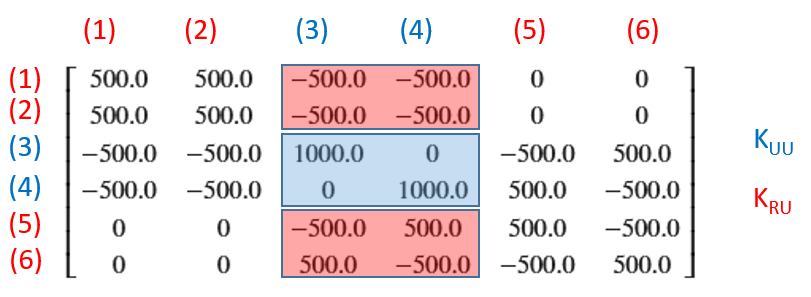

In [16]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/Kuu_vs_Kru.png", width=800)

Ομοίως και για τα μητρώα εξωτερικής φόρτισης, παραμορφώσεων και αντιδράσεων

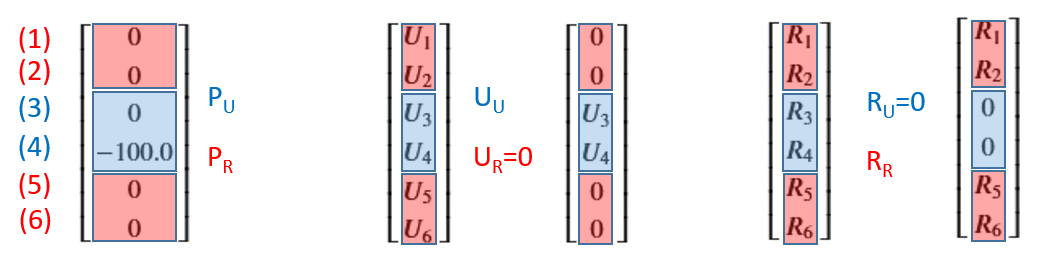

In [17]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example9/PUR.png", width=700)

### Υπομητρώα στιβαρότητας

In [142]:
K_UU = sym.zeros(8,8)
K_UU[0:4, 0:4] += K[2:6, 2:6]
K_UU[0:4, 4:8] += K[2:6, 8:12]
K_UU[4:8, 0:4] += K[8:12, 2:6]
K_UU[4:8, 4:8] += K[8:12, 8:12]
round_expr(K_UU, 1)

Matrix([
[181011.5,  28284.3, -80000.0,        0,        0,        0, -28284.3, -28284.3],
[ 28284.3, 108284.3,        0,        0,        0, -80000.0, -28284.3, -28284.3],
[-80000.0,        0, 181011.5, -28284.3, -28284.3,  28284.3,        0,        0],
[       0,        0, -28284.3, 108284.3,  28284.3, -28284.3,        0, -80000.0],
[       0,        0, -28284.3,  28284.3, 137747.9,  -1499.1, -80000.0,        0],
[       0, -80000.0,  28284.3, -28284.3,  -1499.1, 132634.4,        0,        0],
[-28284.3, -28284.3,        0,        0, -80000.0,        0, 137747.9,   1499.1],
[-28284.3, -28284.3,        0, -80000.0,        0,        0,   1499.1, 132634.4]])

In [143]:
K_RU = sym.zeros(4,8)
K_RU[0:2, 0:4] += K[0:2, 2:6]
K_RU[0:2, 4:8] += K[0:2, 8:12]
K_RU[2:4, 0:4] += K[6:8, 2:6]
K_RU[2:4, 4:8] += K[6:8, 8:12]

round_expr(K_RU, 1)

Matrix([
[-72727.3, 0,        0, 0, -29463.7, -26785.2,        0,        0],
[       0, 0,        0, 0, -26785.2, -24350.1,        0,        0],
[       0, 0, -72727.3, 0,        0,        0, -29463.7,  26785.2],
[       0, 0,        0, 0,        0,        0,  26785.2, -24350.1]])

### Υπομητρώα εξωτερικής φόρτισης

In [150]:
P_U = P[[2, 3, 4, 5, 8, 9, 10, 11], 0]
round_expr(P_U, 2)

Matrix([
[     0],
[     0],
[     0],
[     0],
[ 100.0],
[-100.0],
[     0],
[-100.0]])

In [151]:
P_R = P[[0, 1, 6, 7], 0]
round_expr(P_R, 2)

Matrix([
[0],
[0],
[0],
[0]])

## Υπολογισμός παραμορφώσεων

Είναι $K_{UU}\cdot U_U = P_U + R_U$, με $R_U=0$

οπότε $K_{UU}\cdot U_U = P_U$

και τελικά $U_U = K_{UU}^{-1}\cdot P_U$

In [152]:
U_U = K_UU.inv() * P_U
round_expr(U_U, 7)

Matrix([
[ 0.0001413],
[-0.0050376],
[ 0.0002884],
[-0.0055685],
[ 0.0019959],
[-0.0050189],
[ 0.0002099],
[-0.0051592]])

## Υπολογισμός αντιδράσεων στήριξης

Είναι $K_{RU}\cdot U_U = P_R + R_R$

οπότε $R_R = K_{RU}\cdot U_U - P_R$

In [153]:
R_R = K_RU*U_U - P_R
round_expr(R_R, 2)

Matrix([
[  65.35],
[  68.75],
[-165.35],
[ 131.25]])

## Επίλυση/έλεγχος με το OpenSees

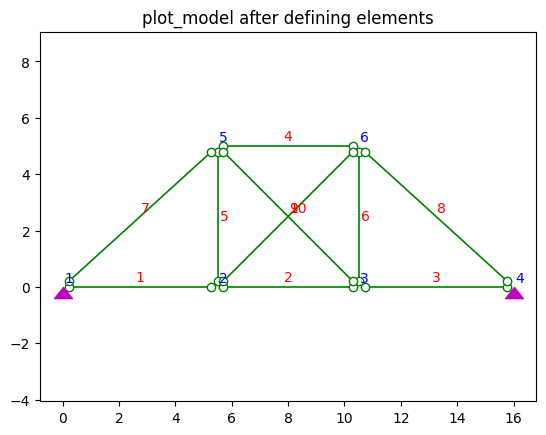

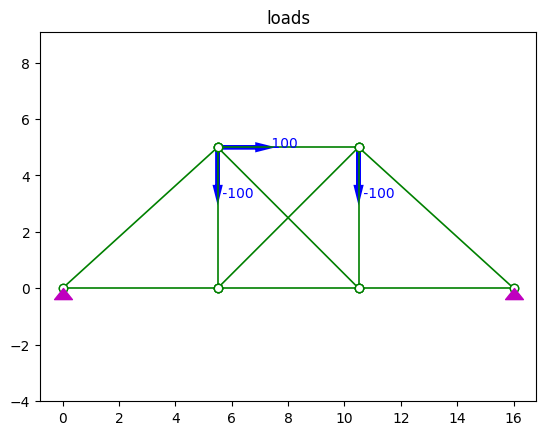

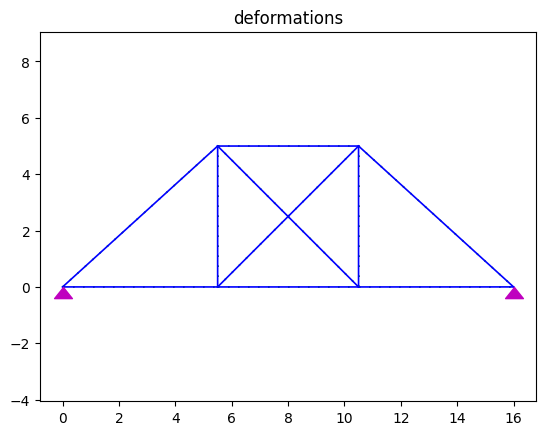

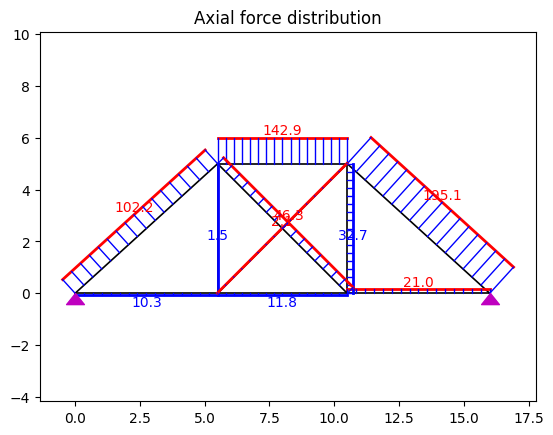

In [5]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 2)

ops.node(1, 0, 0)
ops.node(2, 1.1*L, 0)
ops.node(3, 2.1*L, 0)
ops.node(4, 3.2*L, 0)
ops.node(5, 1.1*L, H)
ops.node(6, 2.1*L, H)

ops.fix(1, 1, 1)
ops.fix(4, 1, 1)

# define materials
ops.uniaxialMaterial("Elastic", 1, E)

# ops.geomTransf('Linear', 1)

# elements
ops.element('Truss', 1, 1, 2, A, 1)
ops.element('Truss', 2, 2, 3, A, 1)
ops.element('Truss', 3, 3, 4, A, 1)

ops.element('Truss', 4, 5, 6, A, 1)

ops.element('Truss', 5, 2, 5, A, 1)
ops.element('Truss', 6, 3, 6, A, 1)

ops.element('Truss', 7, 1, 5, A, 1)
ops.element('Truss', 8, 6, 4, A, 1)

ops.element('Truss', 9, 2, 6, A, 1)
ops.element('Truss', 10, 5, 3, A, 1)


# loads
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)

ops.load(5, F, -F)
ops.load(6, 0, -F)

# analysis
ops.constraints('Plain')
ops.numberer('RCM')
ops.system('BandSPD')
# ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.integrator('LoadControl', 1.0)
ops.algorithm('Linear')
ops.analysis('Static')
ops.analyze(1)

# results
# ops.printModel()
opsv.plot_model()
plt.title('plot_model after defining elements')

opsv.plot_loads_2d()
plt.title('loads')

sfac = .01
opsv.plot_defo(sfac)
plt.title('deformations')

sfacN, sfacV, sfacM = 7.e-3, 6.e-3, 4.e-3
opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')

plt.show()


In [9]:
for i in range(1,7):
    print(ops.nodeDisp(i))

[0.0, 0.0]
[0.0028253982523427906, -0.10075183868726319]
[0.005768351747657232, -0.1113708146371996]
[0.0, 0.0]
[0.03991781459120211, -0.10037742905771489]
[0.004198474220750419, -0.10318390500765132]


In [26]:
# U1, U2, U3, U4, U5, U6 = sym.symbols('U1 U2 U3 U4 U5 U6')
# P1, P2, P3, P4, P5, P6 = sym.symbols('P1 P2 P3 P4 P5 P6')
# R1, R2, R3, R4, R5, R6 = sym.symbols('R1 R2 R3 R4 R5 R6')

In [27]:
# U = Matrix([[U1], [U2], [U3], [U4], [U5], [U6]])
# U

In [28]:
# U.subs(U1, 0).subs(U2, 0).subs(U5, 0).subs(U6, 0)

In [29]:
# R = Matrix([[R1], [R2], [R3], [R4], [R5], [R6]])
# R

In [30]:
# R.subs(R3, 0).subs(R4, 0)

In [31]:
# Λ = Matrix([['cosθ', 0], ['sinθ', 0], [0, 'cosθ'], [0, 'sinθ']])
# Λ